In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nicer
sns.set(style="whitegrid")


In [15]:
# Load the CSV files
trades = pd.read_csv("Trade.csv")
users = pd.read_csv("User.csv")

# Check the first few rows
print("Trades data:")
display(trades.head())

print("\nUsers data:")
display(users.head())


FileNotFoundError: [Errno 2] No such file or directory: 'Trade.csv'

In [ ]:
# Load the CSV files
trades = pd.read_csv("trades.csv")
users = pd.read_csv("user_activity.csv")

# Check the first few rows
print("Trades data:")
display(trades.head())

print("\nUsers data:")
display(users.head())


Trades data:


,pair,amount,volume,side,timestamp,user_id
0,AAVENGN,500.26,0.001222,buy,2024-12-03T01:42:07.072672Z,541-1561-1521-1561-148
1,ADANGN,889.20,0.500000,sell,2024-12-02T11:29:56.860014Z,491-1541-1521-1571-156
2,ADANGN,30653.12,17.100000,sell,2024-11-30T05:25:49.99166Z,1021-1481-1521-1561-1100
3,ADANGN,1978.36,1.100000,sell,2024-12-07T07:41:02.191598Z,981-1571-1521-1971-151
4,ADANGN,2913.62,1.600000,sell,2024-12-07T21:16:11.791118Z,981-1571-1521-1971-151



Users data:


,asset,amount,activity_type,timestamp,user_id
0,NGN,131062.0,withdrawal,2025-01-17T14:37:56.806446Z,561-1561-1521-1981-1101
1,NGN,50000.0,withdrawal,2025-01-17T14:37:56.818033Z,971-11001-1521-1571-1101
2,NGN,131062.0,deposit,2025-01-17T14:37:56.853225Z,481-11011-1521-1971-1100
3,NGN,20064.0,withdrawal,2025-01-17T17:05:18.201218Z,531-11001-1521-1571-198
4,NGN,2000.0,withdrawal,2025-01-17T14:38:22.555744Z,501-11021-1521-1561-154


In [ ]:
trades['usd_volume'] = trades['volume'] * 1500

top_pairs = trades.groupby('pair')['usd_volume'].sum().sort_values(ascending=False).head(3)

print("Top 3 most traded pairs by USD volume:")
display(top_pairs)


Top 3 most traded pairs by USD volume:


pair
BTTNGN      9.616311e+10
PEPEUSDT    1.129093e+10
PEPENGN     7.538645e+09
Name: usd_volume, dtype: float64

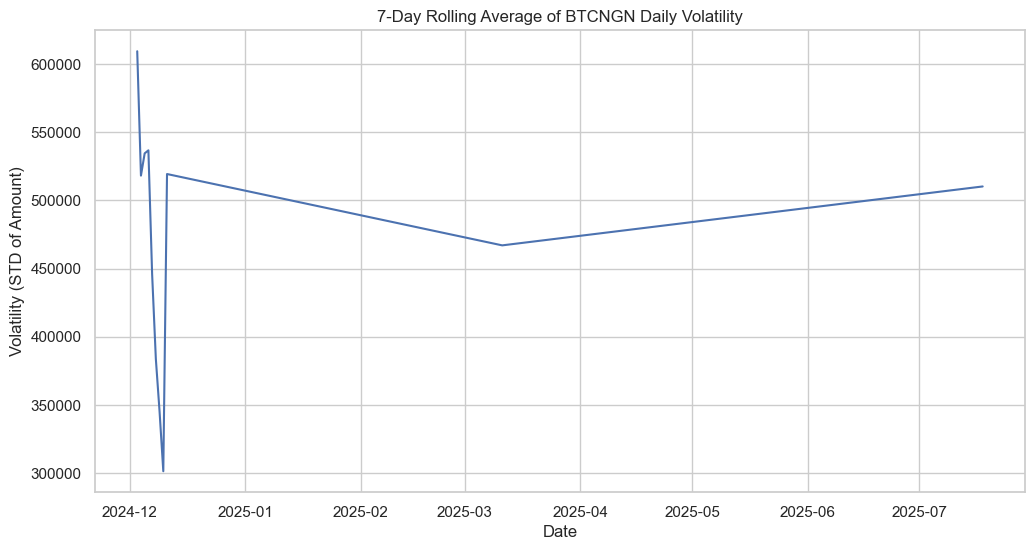

In [ ]:
btc = trades[trades['pair'] == 'BTCNGN'].copy()

btc['timestamp'] = pd.to_datetime(btc['timestamp'])

btc['date'] = btc['timestamp'].dt.date

daily_vol = btc.groupby('date')['amount'].std()

rolling_vol = daily_vol.rolling(window=7).mean()

# Plot
plt.figure(figsize=(12,6))
rolling_vol.plot()
plt.title('7-Day Rolling Average of BTCNGN Daily Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (STD of Amount)')
plt.show()


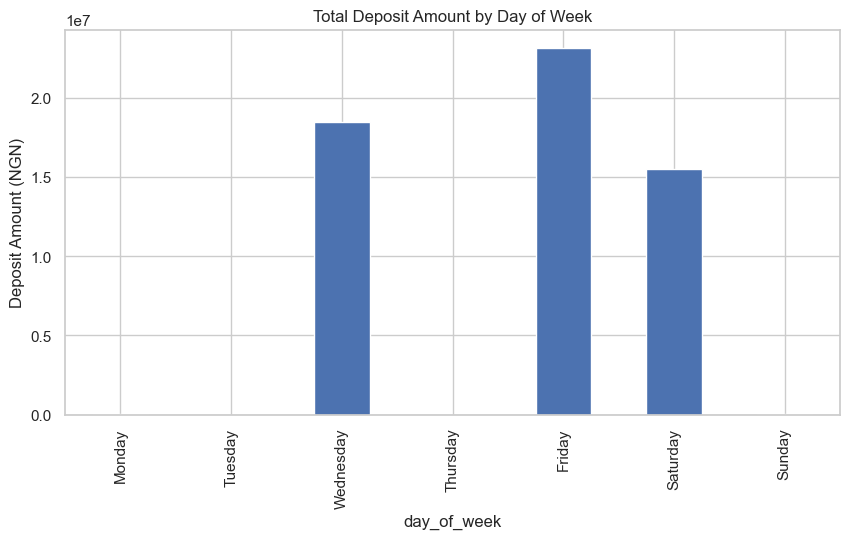

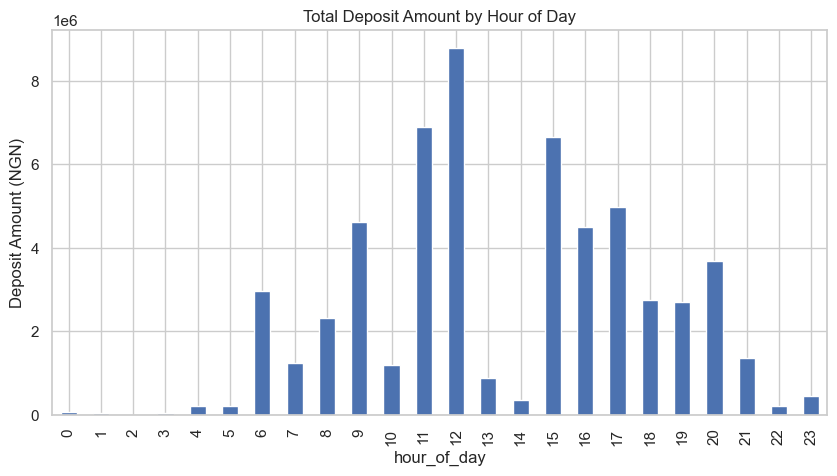

In [ ]:
# Filter only deposits
deposits = users[users['activity_type'] == 'deposit'].copy()

# Convert timestamp to datetime
deposits['timestamp'] = pd.to_datetime(deposits['timestamp'])

# Extract day of week and hour
deposits['day_of_week'] = deposits['timestamp'].dt.day_name()
deposits['hour_of_day'] = deposits['timestamp'].dt.hour

# Count deposits by day
day_counts = deposits.groupby('day_of_week')['amount'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

# Count deposits by hour
hour_counts = deposits.groupby('hour_of_day')['amount'].sum()

# Plot deposits by day
plt.figure(figsize=(10,5))
day_counts.plot(kind='bar')
plt.title('Total Deposit Amount by Day of Week')
plt.ylabel('Deposit Amount (NGN)')
plt.show()

# Plot deposits by hour
plt.figure(figsize=(10,5))
hour_counts.plot(kind='bar')
plt.title('Total Deposit Amount by Hour of Day')
plt.ylabel('Deposit Amount (NGN)')
plt.show()


In [ ]:
trades["timestamp"] = pd.to_datetime(trades["timestamp"], unit="s")
users["timestamp"] = pd.to_datetime(users["timestamp"], unit="s")


In [ ]:


trades["trade_value"] = trades["amount"] * trades["volume"]

# 3. Trade Features Per User
trade_features = trades.groupby("user_id").agg(
    total_trade_value=("trade_value", "sum"),
    trade_count=("trade_value", "count"),
    unique_pairs=("pair", "nunique")
).reset_index()

# 4. Deposit & Withdrawal Features
deposits = users[users["activity_type"] == "deposit"]
withdrawals = users[users["activity_type"] == "withdrawal"]

deposit_features = deposits.groupby("user_id").agg(
    deposit_count=("activity_type", "count"),
    first_deposit=("timestamp", "min")
).reset_index()

withdrawal_features = withdrawals.groupby("user_id").agg(
    withdrawal_count=("activity_type", "count"),
    first_withdrawal=("timestamp", "min")
).reset_index()

# 5. Merge All Features
user_df = deposit_features.merge(
    withdrawal_features,
    on="user_id",
    how="outer"
).merge(
    trade_features,
    on="user_id",
    how="left"
)

# 6. Fill ONLY numeric columns
numeric_cols = [
    "deposit_count",
    "withdrawal_count",
    "total_trade_value",
    "trade_count",
    "unique_pairs"
]

user_df[numeric_cols] = user_df[numeric_cols].fillna(0)

# 7. Time Between Deposit & Withdrawal
user_df["time_to_withdraw_hours"] = (
    (user_df["first_withdrawal"] - user_df["first_deposit"])
    .dt.total_seconds() / 3600
)

user_df["time_to_withdraw_hours"] = user_df["time_to_withdraw_hours"].fillna(0)


# 8. Create Suspicious Label
user_df["is_suspicious"] = np.where(
    (user_df["deposit_count"] > 0) &
    (user_df["withdrawal_count"] > 0) &
    (user_df["trade_count"] <= 2) &
    (user_df["time_to_withdraw_hours"] < 24),
    1,
    0
)

# 9. Model Building
X = user_df[[
    "deposit_count",
    "withdrawal_count",
    "trade_count",
    "unique_pairs",
    "total_trade_value",
    "time_to_withdraw_hours"
]]

y = user_df["is_suspicious"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# 10. Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      1.00      1.00        98

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

Recall: 1.0
Precision: 1.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, precision_score



Part 3: Strategic Recommendation
Defining the "Low-Volume Trader" Segment in Kenya

To support the proposed marketing campaign, we define “Low-Volume Traders” in Kenya using behavioral and transactional data.

Step 1: Identify Kenya Users
Users trading currency pairs ending in KES (e.g., ETHKES, BTCKES) are considered part of the Kenya market segment.

Step 2: Define Low-Volume Behavior
We define low-volume traders using the following data points:
    Total Trade Value
Users whose total trading volume falls in the lower 30th percentile of all Kenya users.

    Trade Count
Users with fewer than 5 total trades over the observed period.

    Number of Unique Pairs Traded
Users trading only 1 asset pair, indicating limited platform engagement.

Strategic Rationale
These users demonstrate low platform engagement and low trading intensity. A targeted campaign could:
Offer fee discounts for increased volume
Provide educational content to boost confidence
Introduce loyalty rewards for reaching trade milestones to encourage them
By focusing on behavioral data rather than assumptions, the campaign becomes data-driven and measurable.